# PINN_NF2_cleanup
> https://github.com/RobertJaro/NF2

## Prepare `b_bottom`

In [ ]:
from zpinn.lowloumag import LowLouMag

In [ ]:
import json

In [ ]:
with open('config.json') as config:
    info = json.load(config)

nx = info['nx']
ny = info['ny']
nz = info['nz']
b_norm = info['b_norm']

In [ ]:
b = LowLouMag(resolutions=[nx, ny, nz])
b.calculate()

UniformGrid (0x7fa2e7362020)
  N Cells:      42404313
  N Points:     42803200
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   512, 418, 200
  Spacing:      3.914e-03, 4.796e-03, 1.005e-02
  N Arrays:     3

In [ ]:
b.bottom

PolyData (0x7fa26c8e7520)
  N Cells:    213087
  N Points:   214016
  N Strips:   0
  X Bounds:   -1.000e+00, 1.000e+00
  Y Bounds:   -1.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   5

In [ ]:
b_bottom = b.b_bottom
b_bottom.shape

(512, 418, 3)

## PINN

$$
\mathbf{B}(z=0)
$$

$$
\mathcal{L}_\text{ff}(\boldsymbol{\theta}; \mathcal{T}_f) = \frac{1}{|\mathcal{T}_f|} \sum_{\boldsymbol{x}\in \mathcal{T}_f} \frac{|(\nabla \times \mathbf{\hat{B}})\times \mathbf{\hat{B}}|^2}{|\mathbf{\hat{B}}|^2}
$$

$$
\mathcal{L}_\text{div}(\boldsymbol{\theta}; \mathcal{T}_f) = \frac{1}{|\mathcal{T}_f|} \sum_{\boldsymbol{x}\in \mathcal{T}_f} |\nabla \cdot \mathbf{\hat{B}}|^2
$$

$$
\mathcal{L}_\text{bc}(\boldsymbol{\theta};\mathcal{T}_b)=\frac{1}{|\mathcal{T}_b|}\sum_{\boldsymbol{x}\in\mathcal{T}_b}{|\mathbf{\hat{B}}-\mathbf{B}|^2}
$$

$$
\mathcal{L} = w_{\text{ff}}\mathcal{L}_\text{ff} + w_{\text{div}}\mathcal{L}_\text{div} +  w_{\text{bc}}\mathcal{L}_{\text{bc}}
$$

In [ ]:
import torch
from torch import nn
from torch.cuda import get_device_name
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler

from tqdm import tqdm
from datetime import datetime
import os
import numpy as np
import json
import logging
import time

In [ ]:
def create_coordinates(bounds):
    xbounds = (bounds[0], bounds[1])
    ybounds = (bounds[2], bounds[3])
    zbounds = (bounds[4], bounds[5])
    meshgrid = np.mgrid[xbounds[0]:xbounds[1]+1, ybounds[0]:ybounds[1]+1, zbounds[0]:zbounds[1]+1]
    return np.stack(meshgrid, axis=-1).astype(np.float32)

In [ ]:
class BoundaryDataset(Dataset):

    def __init__(self, batches_path):
        self.batches_path = batches_path

    def __len__(self):
        return np.load(self.batches_path, mmap_mode='r').shape[0]

    def __getitem__(self, idx):
        # lazy load data
        d = np.load(self.batches_path, mmap_mode='r')[idx]
        d = np.copy(d)
        coord, field = d[:, 0],  d[:, 1]
        return coord, field

In [ ]:
class PotentialModel(nn.Module):

    def __init__(self, b_n, r_p):
        super().__init__()
        self.register_buffer('b_n', b_n)
        self.register_buffer('r_p', r_p)
        c = np.array([[0, 0, 1/np.sqrt(2*np.pi)]])
        c = torch.tensor(c, dtype=torch.float64)
        self.register_buffer('c', c)

    def forward(self, r):
        numerator = self.b_n[:, None]
        denominator = torch.sqrt(torch.sum((r[None, :] - self.r_p[:, None] + self.c[None])**2, -1))
        potential = torch.sum(numerator/denominator, 0) / (2*np.pi)
        return potential

def prepare_bc_data(b_bottom, height, b_norm, spatial_norm, iszero=False):
    Nx, Ny, _ = b_bottom.shape
    Nz = height

    bottom_values = b_bottom.reshape(-1, 3)
    bottom_bounds = (0, Nx-1, 0, Ny-1, 0, 0)
    bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)

    norms = {}
    if b_norm is None:
        bottom_values_abs_max = np.max([np.abs(np.max(bottom_values)), np.abs(np.min(bottom_values))])
        b_norm = int(bottom_values_abs_max)
        norms['b_norm'] = b_norm
    if spatial_norm is None:
        bottom_coords_max = np.max([np.abs(np.max(bottom_coords)), np.abs(np.min(bottom_coords))])
        spatial_norm = int(bottom_coords_max)
        norms['spatial_norm'] = spatial_norm

    top_bounds = (0, Nx-1, 0, Ny-1, Nz-1, Nz-1)
    lateral_bounds_1 = (0, 0, 0, Ny-1, 0, Nz-1)
    lateral_bounds_2 = (Nx-1, Nx-1, 0, Ny-1, 0, Nz-1)
    lateral_bounds_3 = (0, Nx-1, 0, 0, 0, Nz-1)
    lateral_bounds_4 = (0, Nx-1, Ny-1, Ny-1, 0, Nz-1)

    top_lateral_coordinates = [create_coordinates(top_bounds).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_1).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_2).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_3).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_4).reshape(-1, 3)]

    if iszero:
        pf_fields = []
        pf_coords = []
        for r_coords in top_lateral_coordinates:
            pf_fields += [np.zeros((r_coords.shape[0], 3))]
            pf_coords += [r_coords]

    else:
        top_lateral_coordinates = [create_coordinates(top_bounds).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_1).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_2).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_3).reshape(-1, 3),
                                    create_coordinates(lateral_bounds_4).reshape(-1, 3)]
                
        b_n = torch.tensor(bottom_values[:, 2], dtype=torch.float64)
        r_p = torch.tensor(bottom_coords, dtype=torch.float64)

        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)

        pf_fields = []
        pf_coords = []
        for r_coords in top_lateral_coordinates:
            r_coords = torch.tensor(r_coords, dtype=torch.float64)
            pf_batch_size = int(np.prod(r_coords.shape[:-1]) // 10)

            fields = []
            for r, in tqdm(DataLoader(TensorDataset(r_coords), batch_size=pf_batch_size, num_workers=2),
                                desc='Potential Boundary'):
                r = r.to(device).requires_grad_(True)
                p_batch = model(r)
                b_p = -1 * torch.autograd.grad(p_batch, r, torch.ones_like(p_batch), retain_graph=True, create_graph=True)[0]
                fields += [b_p.clone().detach().cpu().numpy()]
            pf_fields += [np.concatenate(fields)]
            pf_coords += [r_coords.clone().detach().cpu().numpy()]

    top_lateral_values = np.concatenate(pf_fields) 
    top_lateral_coords = np.concatenate(pf_coords)

    boundary_values = np.concatenate([top_lateral_values, bottom_values])
    boundary_coords = np.concatenate([top_lateral_coords, bottom_coords])

    normalized_boundary_values = boundary_values / b_norm
    normalized_boundary_coords = boundary_coords / spatial_norm

    boundary_data = np.stack([normalized_boundary_coords, normalized_boundary_values], 1)

    return boundary_data, norms


In [ ]:
class BModel(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_neurons, num_layers):
        super().__init__()
        self.d_in = nn.Linear(num_inputs, num_neurons)
        lin = [nn.Linear(num_neurons, num_neurons) for _ in range(num_layers)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(num_neurons, num_outputs)
        self.activation = torch.sin

    def forward(self, x):
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        B = self.d_out(x)
        return B

In [ ]:
class NF2Trainer:
    def __init__(self, base_path, b_bottom, height, b_norm=None, spatial_norm=None, meta_info=None, iszero=False):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        # meta info
        self.meta_info = meta_info

        # path
        self.base_path = base_path
        os.makedirs(self.base_path, exist_ok=True)

        # prepare boundary points + values
        self.b_bottom = b_bottom
        self.height = height
        
        self.b_norm = b_norm
        self.spatial_norm = spatial_norm
        self.boundary_data, norms = prepare_bc_data(self.b_bottom, self.height, self.b_norm, self.spatial_norm, iszero)

        if self.b_norm is None:
            self.b_norm = norms['b_norm']
        if self.spatial_norm is None:
            self.spatial_norm = norms['spatial_norm']
        
        # prepare collocation points
        Nx, Ny, _ = self.b_bottom.shape
        Nz = self.height
        self.cube_shape = (Nx, Ny, Nz)
        collocation_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
        collocation_coords = create_coordinates(collocation_bounds).reshape(-1, 3)
        normalized_collocation_coords = collocation_coords / self.spatial_norm
        self.normalized_collocation_coords = torch.tensor(normalized_collocation_coords)  

    def setup(self, total_iterations=50000, batch_size=10000, log_interval=100, num_workers=None,
              num_neurons=256, num_layers=8, w_ff=1, w_div=1, w_bc_init=1000, w_bc_decay_iterations=None,
              transfer_learning_path=None, lr_decay_iterations=None, lr_init=5e-4, lr_final=5e-5):
        device = self.device
                        
        self.total_iterations = total_iterations
        self.batch_size = batch_size
        self.log_interval = log_interval
        self.num_workers = os.cpu_count() if num_workers is None else num_workers

        # setup model and optimizer
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # self.model = nn.DataParallel(BModel(3, 3, num_layers)).to(device)
        self.model = nn.DataParallel(BModel(3, 3, num_neurons, num_layers)).to(device)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr_init)
        if lr_decay_iterations is not None:
            self.scheduler = ExponentialLR(self.opt, gamma=(lr_final / lr_init) ** (1 / lr_decay_iterations))
        else:
            self.scheduler = ExponentialLR(self.opt, gamma=(lr_final / lr_init) ** (1 / total_iterations))

        # loss weights
        self.w_ff = w_ff
        self.w_div = w_div
        self.w_bc = w_bc_init
        if w_bc_decay_iterations is not None:
            self.w_bc_decay = (1 / w_bc_init) ** (1 / w_bc_decay_iterations)
        else:
            self.w_bc_decay = 1

        self.required_iteration = self.total_iterations
        self.start_iteration = 0
        if transfer_learning_path is None:          
            checkpoint_path = os.path.join(self.base_path, 'checkpoint.pt')
            if os.path.exists(checkpoint_path):
                state_dict = torch.load(checkpoint_path, map_location=device)
                self.start_iteration = state_dict['iteration']
                self.model.load_state_dict(state_dict['m'])
                self.opt.load_state_dict(state_dict['o'])
                self.w_bc = state_dict['w_bc']
                print("Resuming training from iteration %d" % self.start_iteration)
                self.required_iteration = self.required_iteration - self.start_iteration
        else:
            state_dict = torch.load(transfer_learning_path, map_location=device)
            self.model.load_state_dict(state_dict['m'])
            self.opt.load_state_dict(state_dict['o'])
            print(f"Load {transfer_learning_path}")

    def train(self):
        device = self.device

        boundary_data_loader, boundary_batches_path = self.create_boundary_batches(self.required_iteration)
        
        start = time.time()
        self.model.train()
        for iter, (boundary_coords, boundary_b) in tqdm(enumerate(boundary_data_loader, start=self.start_iteration),
                                                        total=len(boundary_data_loader), desc='Training'):
            # PDE loss
            perm = torch.randperm(self.normalized_collocation_coords.shape[0])
            idx = perm[:self.batch_size]
            co_coords = self.normalized_collocation_coords[idx].to(device)
            r = co_coords
            r.requires_grad = True                   
            B = self.model(r)
            self.loss_ff, self.loss_div = self.PDEloss(B, r)
                                                            
            # boundary loss
            boundary_coords, boundary_b = boundary_coords.to(device), boundary_b.to(device)
            boundary_B = self.model(boundary_coords)                                 
            loss_bc = torch.sum((boundary_B - boundary_b)**2, dim=-1)
            self.loss_bc = torch.mean(loss_bc)

            # total loss
            self.loss = self.w_bc*self.loss_bc + self.w_ff*self.loss_ff + self.w_div*self.loss_div

            # save initial state
            if iter == 0:
                self.print_log(iter)
                self.save(iter)

            self.opt.zero_grad()
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
            self.opt.step()

            # save checkpoint state
            if (self.log_interval > 0 and (iter + 1) % self.log_interval == 0):
                self.print_log(iter+1)
                self.save(iter+1)
                self.save_state_dict(iter+1, 'checkpoint.pt')

            # update training parameters
            if self.w_bc > 1:
                self.w_bc *= self.w_bc_decay
                if self.w_bc <= 1:
                    self.w_bc = 1
            if self.scheduler.get_last_lr()[0] > 5e-5:
                self.scheduler.step()

        runtime = time.time() - start
        print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(self.total_iterations)*1000):.2f}ms/iter.)')
        # save final model state
        self.print_log(self.total_iterations)
        self.save(self.total_iterations)
        self.save_state_dict(self.total_iterations, 'model_final.pt')
        # cleanup
        os.remove(boundary_batches_path)    

    def create_boundary_batches(self, required_iterations):
        boundary_data = self.boundary_data
        batch_size = self.batch_size
        num_workers = self.num_workers
        
        # shuffle data
        r = np.random.permutation(boundary_data.shape[0])
        boundary_data = boundary_data[r]
    
        # adjust to batch size
        pad = batch_size - boundary_data.shape[0] % batch_size
        boundary_data = np.concatenate([boundary_data, boundary_data[:pad]])
    
        # split data into batches
        n_batches = boundary_data.shape[0] // batch_size
        boundary_batches = np.array(np.split(boundary_data, n_batches), dtype=np.float32)
    
        # store batches to disk
        boundary_batches_path = os.path.join(self.base_path, 'boundary_batches.npy')
        np.save(boundary_batches_path, boundary_batches)
        # create data loaders
        boundary_dataset = BoundaryDataset(boundary_batches_path)
        # create loader
        boundary_data_loader = DataLoader(boundary_dataset, batch_size=None, num_workers=num_workers, pin_memory=True,
                                 sampler=RandomSampler(boundary_dataset, replacement=True, num_samples=required_iterations))
        return boundary_data_loader, boundary_batches_path

    def PDEloss(self, B, r):
        dBx_dr = torch.autograd.grad(B[:, 0], r, torch.ones_like(B[:, 0]), retain_graph=True, create_graph=True)[0]
        dBy_dr = torch.autograd.grad(B[:, 1], r, torch.ones_like(B[:, 1]), retain_graph=True, create_graph=True)[0]
        dBz_dr = torch.autograd.grad(B[:, 2], r, torch.ones_like(B[:, 2]), retain_graph=True, create_graph=True)[0]

        dBx_dx = dBx_dr[:, 0]
        dBx_dy = dBx_dr[:, 1]
        dBx_dz = dBx_dr[:, 2]

        dBy_dx = dBy_dr[:, 0]
        dBy_dy = dBy_dr[:, 1]
        dBy_dz = dBy_dr[:, 2]

        dBz_dx = dBz_dr[:, 0]
        dBz_dy = dBz_dr[:, 1]
        dBz_dz = dBz_dr[:, 2]

        rot_x = dBz_dy - dBy_dz
        rot_y = dBx_dz - dBz_dx
        rot_z = dBy_dx - dBx_dy

        J = torch.stack([rot_x, rot_y, rot_z], -1)
        JxB = torch.cross(J, B, dim=-1)

        divB = dBx_dx + dBy_dy + dBz_dz

        loss_ff = torch.sum(JxB**2, dim=-1) / (torch.sum(B**2, dim=-1) + 1e-7)
        loss_ff = torch.mean(loss_ff)
        # loss_div = torch.sum((divB)**2, dim=-1)
        # loss_div = torch.mean(loss_div)
        loss_div = torch.mean((divB)**2)

        return loss_ff, loss_div
        
    def save(self, iteration):
        torch.save({'iteration': iteration,
                    'model': self.model,
                    'cube_shape': self.cube_shape,
                    'b_norm': self.b_norm,
                    'spatial_norm': self.spatial_norm,
                    'loss_bc': self.loss_bc.detach().cpu().numpy(),
                    'w_bc': self.w_bc,
                    'loss_div': self.loss_div.detach().cpu().numpy(),
                    'w_div': self.w_div,
                    'loss_ff': self.loss_ff.detach().cpu().numpy(),
                    'w_ff': self.w_ff,
                    'LR':self.scheduler.get_last_lr()[0]}, 
                    os.path.join(self.base_path, 'model_%06d.pt' % iteration))
        
    def save_state_dict(self, iteration, filename):
        torch.save({'iteration': iteration,
                    'w_bc': self.w_bc,
                    'm': self.model.state_dict(),
                    'o': self.opt.state_dict()},
                    os.path.join(self.base_path, filename))

    def print_log(self, iteration):
        print('[Iteration %06d/%06d] [loss: %.08f] [loss_bc: %.08f; loss_div: %.08f; loss_ff: %.08f] [w_bc: %f, LR: %f]' %
                (iteration, self.total_iterations,
                self.loss,
                self.w_bc*self.loss_bc,
                self.w_ff*self.loss_ff,
                self.w_div*self.loss_div,
                self.w_bc,
                self.scheduler.get_last_lr()[0]))

## Training

In [ ]:
base_path="results"
trainer = NF2Trainer(base_path, b_bottom, height=nz, b_norm=100, spatial_norm=32, meta_info=None, iszero=True)

In [ ]:
trainer.setup(total_iterations=2000, batch_size=10000, log_interval=100, num_workers=None,
              num_neurons=256, num_layers=8, w_ff=1, w_div=1, w_bc_init=1000, w_bc_decay_iterations=10000,
              lr_init=5e-4, lr_final=5e-5, lr_decay_iterations=10000)
              # transfer_learning_path='/home/tensor/workspace/Python_stuff/zpinn/nbs/results/simul_01/model_final.pt')

In [ ]:
from torchinfo import summary

In [ ]:
trainer.model

DataParallel(
  (module): BModel(
    (d_in): Linear(in_features=3, out_features=256, bias=True)
    (linear_layers): ModuleList(
      (0-7): 8 x Linear(in_features=256, out_features=256, bias=True)
    )
    (d_out): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
summary(trainer.model)

Layer (type:depth-idx)                   Param #
DataParallel                             --
├─BModel: 1-1                            --
│    └─Linear: 2-1                       1,024
│    └─ModuleList: 2-2                   --
│    │    └─Linear: 3-1                  65,792
│    │    └─Linear: 3-2                  65,792
│    │    └─Linear: 3-3                  65,792
│    │    └─Linear: 3-4                  65,792
│    │    └─Linear: 3-5                  65,792
│    │    └─Linear: 3-6                  65,792
│    │    └─Linear: 3-7                  65,792
│    │    └─Linear: 3-8                  65,792
│    └─Linear: 2-3                       771
Total params: 528,131
Trainable params: 528,131
Non-trainable params: 0

In [ ]:
trainer.cube_shape

(512, 418, 200)

In [ ]:
trainer.b_norm, trainer.spatial_norm

(100, 32)

In [ ]:
trainer.train()

Training:   0%|          | 1/2000 [00:02<1:11:12,  2.14s/it]

[Iteration 000000/002000] [loss: 71.68433380] [loss_bc: 71.68431854; loss_div: 0.00000509; loss_ff: 0.00000816] [w_bc: 1000.000000, LR: 0.000500]


Training:   1%|          | 15/2000 [00:19<44:05,  1.33s/it] 


KeyboardInterrupt: 

# Visualization

In [ ]:
from zpinn.pinn_nf2_visualization import pinn_cube, draw_grid

In [ ]:
import pyvista as pv

In [ ]:
pv.set_jupyter_backend('static')

In [ ]:
save_path = '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_002000.pt'

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
state = torch.load(save_path, map_location=device)
model = state['model']
cube_shape = state['cube_shape']
b_norm = state['b_norm']
spatial_norm = state['spatial_norm']
batch_size = 10000

Nx, Ny, Nz = cube_shape

co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
normalized_co_coords = co_coords / spatial_norm
normalized_co_coords = torch.tensor(normalized_co_coords)
                                                   
n_batch = int(np.ceil(normalized_co_coords.shape[0] / batch_size))

cube = []
for k in tqdm(range(n_batch)):
    batch_coords = normalized_co_coords[k*batch_size : (k+1)*batch_size]
    batch_coords.to(device)
    cube += [model(batch_coords).detach().cpu()]
cube = torch.concatenate(cube)
B = cube.numpy()*b_norm

  0%|          | 0/82 [00:00<?, ?it/s]

100%|██████████| 82/82 [00:00<00:00, 181.21it/s]


In [ ]:
co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]

In [ ]:
Bs = B.reshape(Nx, Ny, Nz, 3)
Bx = Bs[..., 0]
By = Bs[..., 1]
Bz = Bs[..., 2]

In [ ]:
grid = pv.StructuredGrid(x, y, z)
vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
grid['B'] = vectors
grid.active_vectors_name = 'B'
magnitude = np.linalg.norm(vectors, axis=-1)
grid['mag'] = magnitude
grid.active_scalars_name = 'mag'

In [ ]:
grid

StructuredGrid (0x7f5ff881eb60)
  N Cells:      792099
  N Points:     819200
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 9.900e+01
  Dimensions:   64, 128, 100
  N Arrays:     2

In [ ]:
pi = draw_grid(grid)

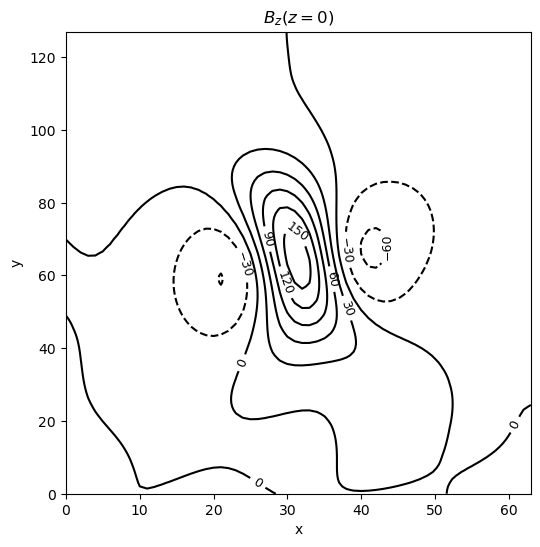

In [ ]:
pi.plt_Bz()

In [ ]:
co_bounds = (0, nx-1, 0, ny-1, 0, nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(nx, ny, nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]

In [ ]:
bgrid = pv.StructuredGrid(x, y, z)
# vectors = np.stack([bx, by, bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
bgrid['B'] = b.grid['B']
bgrid.active_vectors_name = 'B'
magnitude = np.linalg.norm(b.grid['B'], axis=-1)
bgrid['mag'] = magnitude
bgrid.active_scalars_name = 'mag'

In [ ]:
bgrid

StructuredGrid (0x7f5fdd502c80)
  N Cells:      792099
  N Points:     819200
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 9.900e+01
  Dimensions:   64, 128, 100
  N Arrays:     2

In [ ]:
bbb = draw_grid(bgrid)

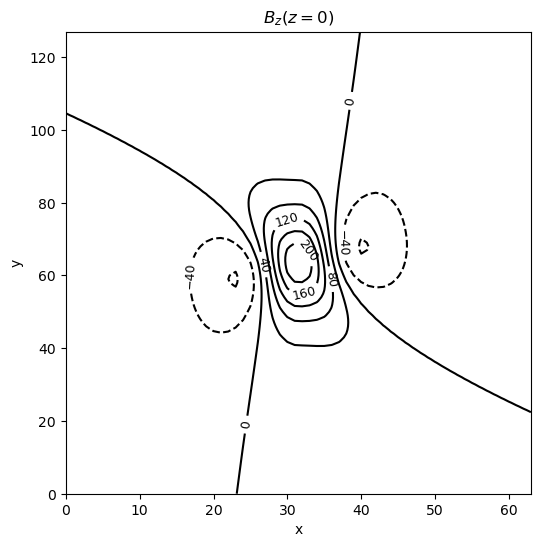

In [ ]:
bbb.plt_Bz()

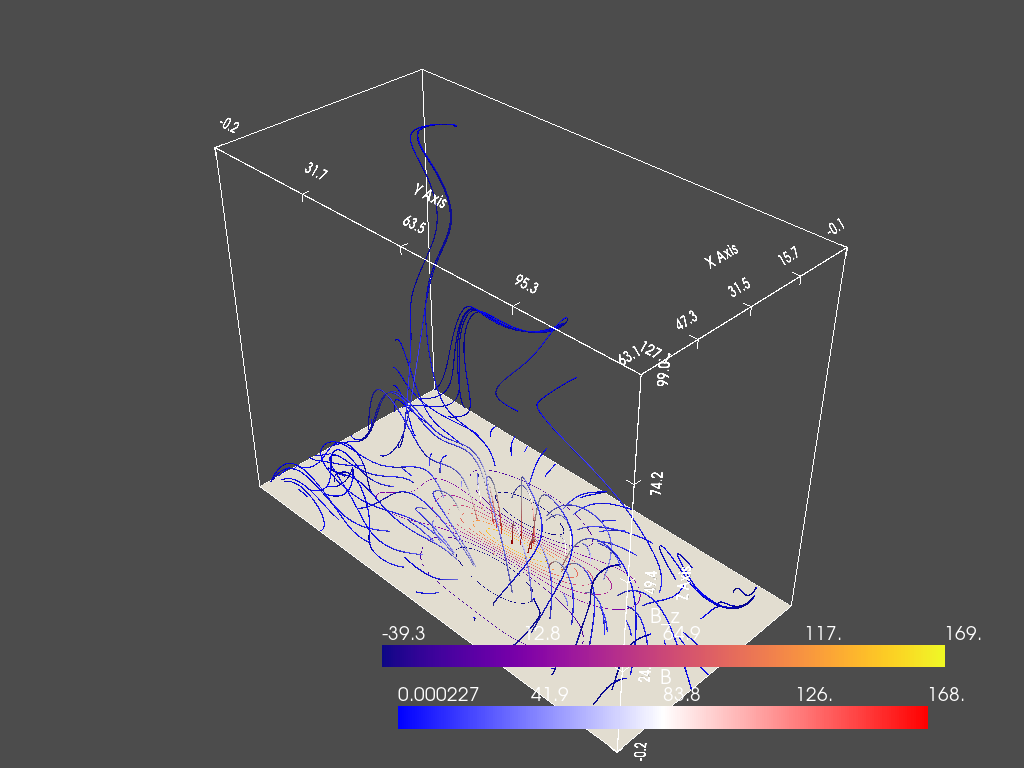

In [ ]:
pi.pv_streamline()

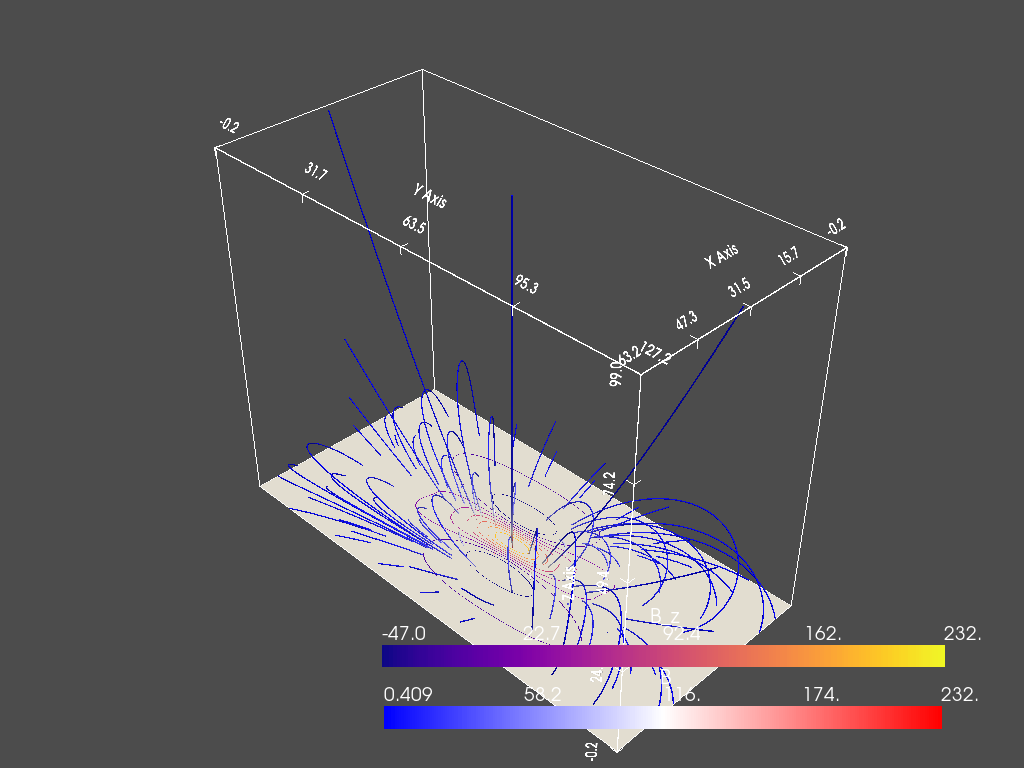

In [ ]:
bbb.pv_streamline()

In [ ]:
b.grid['B']

pyvista_ndarray([[-0.2634365 ,  1.18534814, -2.10842002],
                 [-0.42860568,  1.14545598, -2.22206668],
                 [-0.60978994,  1.09008132, -2.33443146],
                 ...,
                 [ 0.23226565,  0.21901985,  0.11374298],
                 [ 0.23606161,  0.21954163,  0.09989331],
                 [ 0.23919628,  0.21975482,  0.08609469]])